# MNIST - Random Number Sum - Pytorch Network

## Assignment

- Write a neural network that can:
    - take 2 inputs:
      - an image from the MNIST dataset (say 5), and
      - a random number between 0 and 9, (say 7)
    - and gives two outputs:
      - the "number" that was represented by the MNIST image (predict 5), and
      - the "sum" of this number with the random number and the input image to  the network (predict 5 + 7 = 12)
      ![im](https://canvas.instructure.com/courses/2734471/files/155148058/preview)
- you can mix fully connected layers and convolution layers
- you can use one-hot encoding to represent the random number input as well as the "summed" output.
    - Random number (7) can be represented as 0 0 0 0 0 0 0 1 0 0
    - Sum (13) can be represented as:
0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
0b1101 (remember that 4 digits in binary can at max represent 15, so we may need to go for 5 digits. i.e. 10010
- Your code MUST be:
  - well documented (via readme file on GitHub and comments in the code)
  - must mention the data representation
  - must mention your data generation strategy (basically the class/method you are using for random number generation)
  - must mention how you have combined the two inputs (basically which layer you are combining)
  - must mention how you are evaluating your results 
  - must mention "what" results you finally got and how did you evaluate your results
  - must mention what loss function you picked and why!
  - training MUST happen on the GPU

## Import Libs

In [ ]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt

## Batch Parameters

In [ ]:
batch_size_train = 64
batch_size_test = batch_size_train

## Some experiments with unsqeeze

In [ ]:
a = torch.randn(4)
b = torch.randn(4, 1)
a

tensor([ 0.5847, -0.4203, -0.4538,  1.2107])

In [ ]:
m = torch.unsqueeze(a,dim=1)

In [ ]:
b

tensor([[ 0.9125],
        [ 0.1052],
        [-1.3628],
        [-0.1293]])

In [ ]:
torch.add(a, b, alpha=10)

tensor([[  9.7094,   8.7044,   8.6709,  10.3354],
        [  1.6367,   0.6317,   0.5982,   2.2627],
        [-13.0433, -14.0483, -14.0818, -12.4173],
        [ -0.7081,  -1.7131,  -1.7466,  -0.0821]])

In [ ]:
torch.add(m, b, alpha=10)

tensor([[  9.7094],
        [  0.6317],
        [-14.0818],
        [ -0.0821]])

## Random Number generation

This logic generates random number between loq and high number. I have kept dimension as equal to training batch size.


In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N = batch_size_train
D_in = 1
D_out = 1
# Create random Tensors to hold inputs and outputs

# x = torch.randn(N, D_in)

x_rand_trn_1 = torch.randint(low=0,
                       high = 20,
                       size =(N,),)
# x_rand_trn
x_rand_trn_1 = x_rand_trn.type(torch.float32)
x_rand_trn_1

tensor([18., 19., 13.,  5., 17.,  7., 10.,  4.,  6.,  1., 10., 14., 14., 17.,
         0.,  4., 11., 16.,  0., 10., 14., 12., 16., 19.,  9.,  9., 12., 19.,
        11., 14.,  8.,  0., 16., 14., 19., 19.,  2.,  5.,  6., 17., 10.,  7.,
        11., 18.,  8.,  8.,  3., 15.,  5., 13.,  7., 19.,  7., 15.,  1., 10.,
        17., 13.,  9., 18.,  0., 11., 16.,  8.])

In [ ]:
N = batch_size_test

x_rand_test_1 = torch.randint(low=0,
                       high = 20,
                       size =(N,))
x_rand_test_1 = x_rand_test.type(torch.float32)


## Dataloader and data analysis

TorchVision let's use load the MNIST dataset in a handy way. We'll use a batch_size of 64 for training and size 1000 for testing on this dataset. The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset.


In [ ]:
class mnist_dataloader(Dataset):
  def __init__(self,
               batch_size_train,
               batch_size_test):
    self.random_seed = 19
    torch.manual_seed(self.random_seed)
    self.batch_size_train = batch_size_train
    self.batch_size_test = batch_size_test
    self.train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                                                                               transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                                                         torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
                                                    batch_size=batch_size_train, shuffle=True, pin_memory=True)

    self.test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                                                                               transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                                                         torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
                                                    batch_size=batch_size_test, shuffle=True, pin_memory=True)
    
    self.train_loader_len = len(self.train_loader.dataset)
    self.test_loader_len = len(self.test_loader.dataset)

In [ ]:
mnist_dataloader = mnist_dataloader(batch_size_train,batch_size_test)
examples = enumerate(mnist_dataloader.test_loader)

So one test data batch is a  tensor of shape: . This means we have 32 examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one). We can plot some of them using matplotlib

In [ ]:
batch_idx, (example_data, example_targets) = next(examples)
batch_idx, example_targets, example_data.shape

(0,
 tensor([0, 4, 7, 4, 0, 2, 4, 7, 9, 0, 0, 9, 8, 8, 9, 3, 6, 8, 4, 7, 4, 9, 6, 8,
         2, 4, 2, 1, 6, 7, 9, 7, 1, 2, 4, 9, 6, 1, 8, 8, 7, 7, 6, 4, 8, 8, 4, 8,
         4, 8, 5, 5, 7, 7, 3, 9, 6, 3, 7, 6, 6, 8, 4, 8]),
 torch.Size([64, 1, 28, 28]))

So one test data batch is a  tensor of shape: . This means we have 1000 examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one). We can plot some of them using matplotlib.

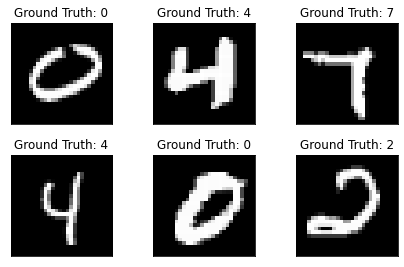

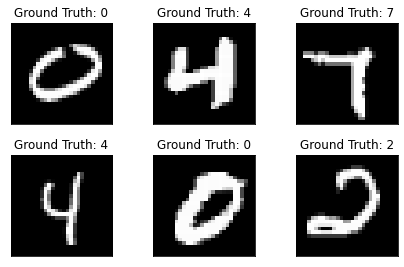

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Network Design

- The forward() pass defines the way we compute our output using the given layers and function
- torch.nn layers as which contain trainable parameters while torch.nn.functional are purely functional. 
- The forward() pass defines the way we compute our output using the given layers and functions

In [ ]:
learning_rate = 0.01
momentum = 0.5
log_interval = 10
n_epochs = 3


- Forward function acceting inout of input image and random number which is generated during training.
- Then i am adding predicted number and random number into forward function as below.
---
    mnist_rand_sum = torch.add(pred_x, torch.unsqueeze(input_random_org,dim=1))  ## adding two numbers
---
- my forward function returning input, random number, predicted number and sum as shared below.


---
    mnist_rand_sum = torch.add(pred_x, torch.unsqueeze(input_random_org,dim=1))  ## adding two numbers
---




In [ ]:
class mnist_network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_b1_1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv_b1_2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    self.conv_b1_drop = nn.Dropout2d()
    self.conv_b1_3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
    self.fc1 = nn.Linear(in_features=24 * 6 * 6, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=10)
    # self.out_prev = nn.Linear(in_features=60, out_features=10)
    # self.fc_size = fc_size
    # self.rand_dim = rand_dim

    # self.ln4 = torch.nn.Linear(in_features=self.rand_dim, out_features=fc_size)
    # self.ln5 = torch.nn.Linear(in_features=self.fc_size, out_features=10)


  def forward(self, input_image, input_random):
    # input layer
    x = input_image

    input_random_org = input_random.type(torch.float32)


    ### mninst image handling logic

    # conv1 layer
    x = self.conv_b1_1(x)
    x = F.relu(x)
    # x = F.max_pool2d(x, kernel_size=2, stride=2) # 32, 6, 13, 13
    # print(x.shape)
    
    x =self.conv_b1_drop(x)

    # conv2 layer
    x = self.conv_b1_2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 32, 12, 5, 5
    # print(x.shape)


    # conv3 layer
    x = self.conv_b1_3(x)  # 32, 24, 6, 6
    x = F.relu(x)
    # print(x.shape)  

    # reshapre
    x = x.reshape(-1, 24 * 6 * 6)

    # fc1 layer
    x = self.fc1(x)
    # x = F.relu(x)

    x = F.dropout(x, training=self.training)
    
    # fc2 layer
    x = self.fc2(x)


    ### random number handling logic
    # print(y.shape)
    # y = self.ln4(y)
    # y = F.relu(y)
    # y = self.ln5(y)

    x = F.log_softmax(x)
    
    pred_x = x.data.max(1, keepdim=True)[1]

    # print(pred_x.shape)
    # print(input_random_org.shape)  

    mnist_rand_sum = torch.add(pred_x, torch.unsqueeze(input_random_org,dim=1))  ## adding two numbers
    # print(pred_x.shape)  ## torch.Size([64, 1])
    # print(input_random_org.shape) ## torch.Size([64])
    # print(mnist_rand_sum.shape) ## torch.Size([64])
    return x, mnist_rand_sum, input_random_org

## Network Training

Now let's initialize the network and the optimizer.

In [ ]:
network = mnist_network()
print(network)

mnist_network(
  (conv_b1_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv_b1_2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv_b1_drop): Dropout2d(p=0.5, inplace=False)
  (conv_b1_3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=864, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


I have used SGD here with momentum. SGD is being used as my loss function is only looking at MNIST number prediction and i am not looking for loss calculation of sum value.

In [ ]:
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

## Model Training

- First we want to make sure our network is in training mode.
- Then we iterate over all training data once per epoch.
- Loading the individual batches is handled by the DataLoader
- First we need to manually set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients. 
- We then produce the output of our network (forward pass) and compute a negative log-likelihodd loss between the output and the ground truth label
- The backward() call we now collect a new set of gradients which we propagate back into each of the network's parameters using optimizer.step()

We'll also keep track of the progress with some printouts. In order to create a nice training curve later on we also create two lists for saving training and testing losses. On the x-axis we want to display the number of training examples the network has seen during training.

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(mnist_dataloader.train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
import os
os.makedirs("results",exist_ok=True)

- Neural network modules as well as optimizers have the ability to save and load their internal state using .state_dict(). 
- With this we can continue training from previously saved state dicts if needed - we'd just need to call .load_state_dict(state_dict). 

***My standard network output and target are when network is only predicting MNIST image:***

- **output**: tensor([[-2.2538, -2.2690, -2.2902, -2.2833, -2.3939, -2.3869, -2.2615, -2.3000,-2.4056, -2.2025]], grad_fn=<LogSoftmaxBackward>)

- **target**: tensor([3])

Neural network modules as well as optimizers have the ability to save and load their internal state using .state_dict(). With this we can continue training from previously saved state dicts if needed - we'd just need to call .load_state_dict(state_dict). 

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(mnist_dataloader.train_loader):
    x_rand_trn = torch.randint(low=0,
                       high = 20,
                       size =(len(data),),)
    # x_rand_trn
    x_rand_trn = x_rand_trn.type(torch.float32)

    optimizer.zero_grad()
    output,mnist_rand_sum,mnist_rand = network(data,x_rand_trn) ## passing input image and random number. both having same batch size
    # print(f"output:{output}")
    # print(f"target:{target}")

    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), mnist_dataloader.train_loader_len,
        100. * batch_idx / len(mnist_dataloader.train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*mnist_dataloader.train_loader_len))
      torch.save(network.state_dict(), '/content/results/mnist-model.pth')
      torch.save(optimizer.state_dict(), '/content/results/mnist-optimizer.pth')

Now for our test loop. Here we sum up the test loss and keep track of correctly classified digits to compute the accuracy of the network. 

In [ ]:
!pwd

/content


Now for our test loop. Here we sum up the test loss and keep track of correctly classified digits to compute the accuracy of the network. 

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in mnist_dataloader.test_loader:
      # print(f"lengh:{len(data)}")
      x_rand_test = torch.randint(low=0,
                                  high = 20,
                                  size =(len(data),),)
    # x_rand_trn
      x_rand_test = x_rand_test.type(torch.float32)      
      output,mnist_rand_sum, mnist_rand = network(data,x_rand_test)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= mnist_dataloader.test_loader_len
  
  test_losses.append(test_loss)

  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, mnist_dataloader.test_loader_len,
    100. * correct / mnist_dataloader.test_loader_len))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3072, Accuracy: 1110/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308383
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.310192
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.293060
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.274329
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.288037
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.285798
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.263713
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.251025
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.253286
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.204738
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.133570
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.046288
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.618983
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.453925
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.147109
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.898455
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.856337
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.918861
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.651475
Train Epoch: 1 [12160

In [ ]:
len(example_data)

64

## Evaluating the Model's Performance

Within just 3 epochs of training we already managed to achieve 97% accuracy on the test set! We started out with randomly initialized parameters and as expected only got about 10% accuracy on the test set before starting the training.

Let's plot our training curve.

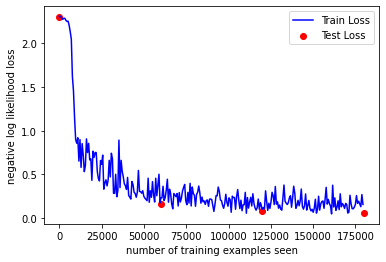

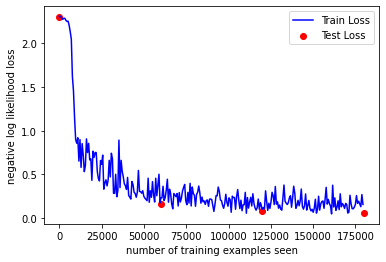

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig


## prediction for manual validation of predicted number and sum

let's again look at a few examples as we did earlier and compare the model's output.

In [ ]:
x_rand_trn = torch.randint(low=0,
                       high = 20,
                       size =(len(example_data),),)
# x_rand_trn
x_rand_trn = x_rand_trn.type(torch.float32)
x_rand_trn

tensor([17., 18.,  8., 14.,  0.,  2., 10.,  1., 13.,  1., 12.,  1., 19.,  4.,
         3.,  1., 16.,  2.,  7., 11., 14.,  7., 12., 19., 15.,  1.,  8.,  9.,
        13.,  7., 10.,  2., 16., 11.,  3., 11.,  3.,  2., 11., 12.,  8.,  5.,
         3.,  0., 17., 10., 11., 13., 15., 13.,  3., 18., 14., 12.,  2.,  9.,
        11.,  7.,  8., 16.,  4., 15., 12., 15.])

In [ ]:
with torch.no_grad():
  output,mnist_rand_sum,mnist_rand = network(example_data,x_rand_trn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
output[6].shape

torch.Size([10])

In [ ]:
mnist_rand[22]

tensor(12.)

In [ ]:
mnist_rand_sum.shape

torch.Size([64, 1])

In [ ]:
mnist_rand_sum[1].item()

22.0

In [ ]:
output.shape

torch.Size([64, 10])

Here I have displayed
- random input number
- Predicted MNIST number
- Sum of random number and predicted MNIST number

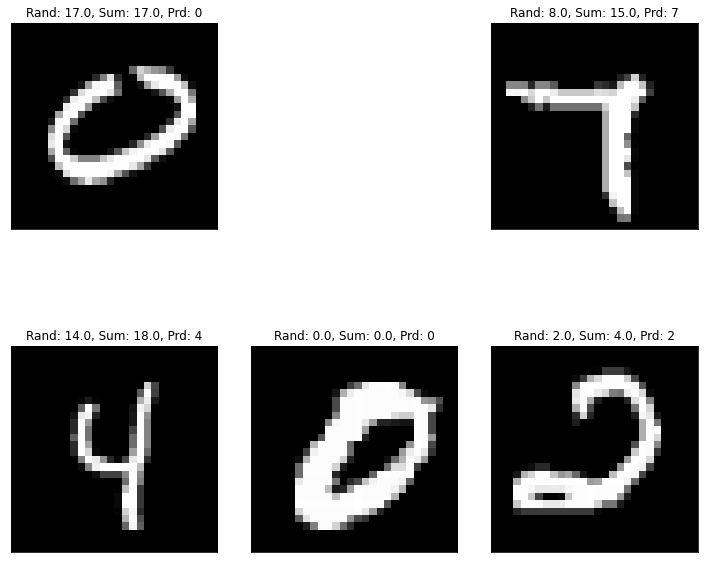

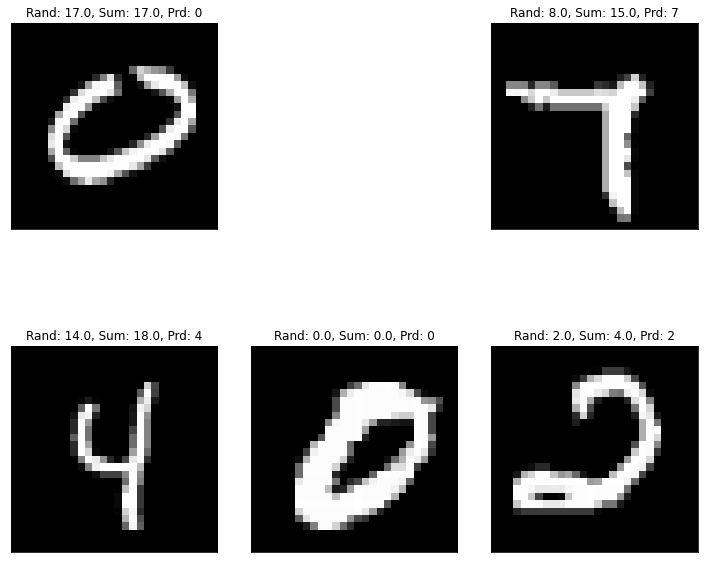

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Rand: {}".format(mnist_rand[i]) + ", Sum: {}".format(mnist_rand_sum[i].item()) + ", Prd: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig


## References

Following articles been referred for this notebook developments

- Multiple Input handling in NN - Pytorch
  - https://stackoverflow.com/questions/53980894/neural-network-using-both-images-and-numerical-inputs
  - https://stackoverflow.com/questions/51700729/how-to-construct-a-network-with-two-inputs-in-pytorch
  - https://rosenfelder.ai/multi-input-neural-network-pytorch/
  - https://discuss.pytorch.org/t/nn-module-with-multiple-inputs/237/2

- Multiple Output handling in NN - Pytorch
    - [A model with multiple outputs](https://discuss.pytorch.org/t/a-model-with-multiple-outputs/10440/10)